ANLY 580 - NLP for Data Analytics
Fall Semester 2019

### Topic Modleing - Latent Dirichlet Allocation (LDA) and Gensim

In [2]:
import os
import pandas as pd
import numpy as np

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel

from nltk.corpus import stopwords
import string
import re
import pprint

from collections import OrderedDict

import seaborn as sns

import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Modify these parmeters for the local directory structre where the data os located. 

data_file_path = "data"
temp_file_path = "backup"

#### Use the train and test data from Semval 2016 Task BD, which includes human annotated topics

In [8]:
# As shown below this example uses the Semval Gold training and test sets from subtask BD 
# which include human annotated tags for use in comparing topic modeling
# interpreation of the content.

# Load the data into a pandas dataframe. 

# Set to True to include additional data from the "test" set. 
INCLUDE_TRAIN = True  # Include the train set by default
INCLUDE_TEST = False  # Set to True to also include the test set, results in longer run times 

# Read the train data into a pandas dataframe 
datafile = os.path.join(data_file_path, "2017_English_final/GOLD/Subtasks_BD/twitter-2016train-BD.txt")
tweets1 = pd.read_csv(datafile, 
                     encoding = 'utf-8', 
                     sep = '\t', 
                     header = None,
                     index_col = False,
                     names = ['msgid', 'topic', 'sentiment', 'Tweet'], 
                     dtype = {'msgid':str, 'topic':str, 'sentiment':str, 'Tweet':str})

# Read the test data into a pandas dataframe
datafile = os.path.join(data_file_path, "2017_English_final/GOLD/Subtasks_BD/twitter-2016test-BD.txt")
tweets2 = pd.read_csv(datafile, 
                     encoding = 'utf-8', 
                     sep = '\t', 
                     header = None,
                     index_col = False,
                     names = ['msgid', 'topic', 'sentiment', 'Tweet'], 
                     dtype = {'msgid':str, 'topic':str, 'sentiment':str, 'Tweet':str})


if INCLUDE_TRAIN and INCLUDE_TEST:
    tweets = pd.concat([tweets1, tweets2], ignore_index=True)
elif INCLUDE_TRAIN:
    tweets = tweets1
else:
    tweets = tweets2


In [9]:
# How many human annotated topics are in the data?

human_topics = list(set(tweets['topic'].tolist()))
print("Number of human topics in the data: {}".format(len(human_topics)))

Number of human topics in the data: 60


In [10]:
# Let's look at the shape of the data, how many tweets are in the data set?
print("Shape of the data: {}".format(tweets.shape))

# And take a look at the first 10 rows
tweets.head(10)

Shape of the data: (4309, 4)


,msgid,topic,sentiment,Tweet
0,628949369883000832,@microsoft,negative,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@microsoft,negative,@Microsoft how about you make a system that do...
2,629023169169518592,@microsoft,negative,I may be ignorant on this issue but... should ...
3,629179223232479232,@microsoft,negative,"Thanks to @microsoft, I just may be switching ..."
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch..."
5,629345637155360768,@microsoft,negative,@MikeWolf1980 @Microsoft I will be downgrading...
6,629394528336637953,@microsoft,negative,@Microsoft 2nd computer with same error!!! #Wi...
7,629650766580609026,@microsoft,positive,Just ordered my 1st ever tablet; @Microsoft Su...
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,..."
9,630159517058142208,@microsoft,positive,"Sunday morning, quiet day so time to welcome i..."


In [11]:
# And take a look at the last 10 rows
tweets.tail(10)

,msgid,topic,sentiment,Tweet
4299,637342059519680513,metlife,negative,Still bitter that they didn't tweet about MetL...
4300,637691185100947456,metlife,positive,I remember buying my tickets to rowyso last ye...
4301,637874723288936448,metlife,positive,"@zourrysscheese hershey for tmh, on americas g..."
4302,638382158420307968,metlife,positive,@uglyuni my mom already bought tickets and the...
4303,638533993344864256,metlife,positive,Schreier Financial Services in Orange City wil...
4304,639166904813223937,metlife,positive,Heading up to MetLife tomorrow for the Jets game
4305,639295526995890177,metlife,positive,Going to MetLife tomorrow but not to see the b...
4306,639804828739346432,metlife,positive,It's the first Football Friday of the year. Th...
4307,639855845958885376,metlife,positive,@Racalto_SK ok good to know. Punting at MetLif...
4308,641034340068143104,metlife,positive,Mendez told me he'd drive me to MetLife on Sun...


Matplotlib is building the font cache using fc-list. This may take a moment.


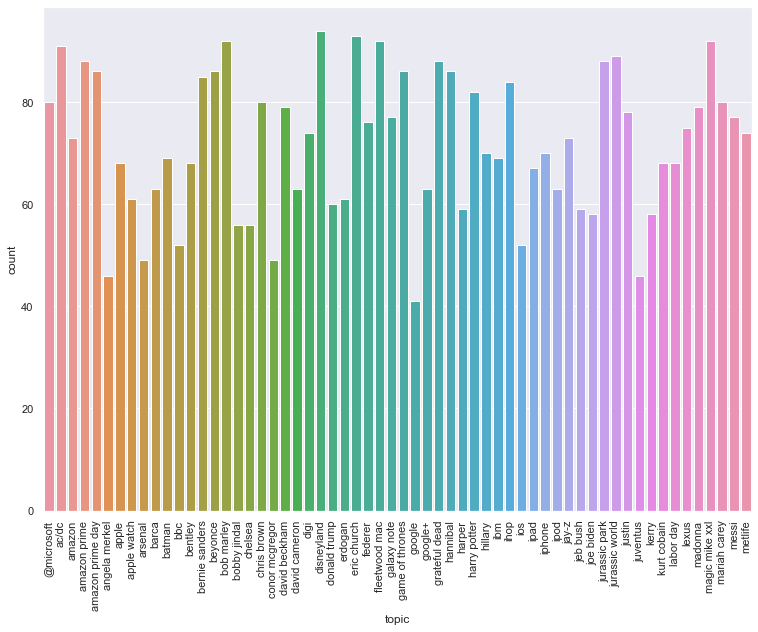

In [12]:
# Take a look at the distributions of human annotated/tagged topics in the data via a barplot

sns.set(rc={'figure.figsize':(12.7,9.27)})
by_topic = sns.countplot(x='topic', data=tweets)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

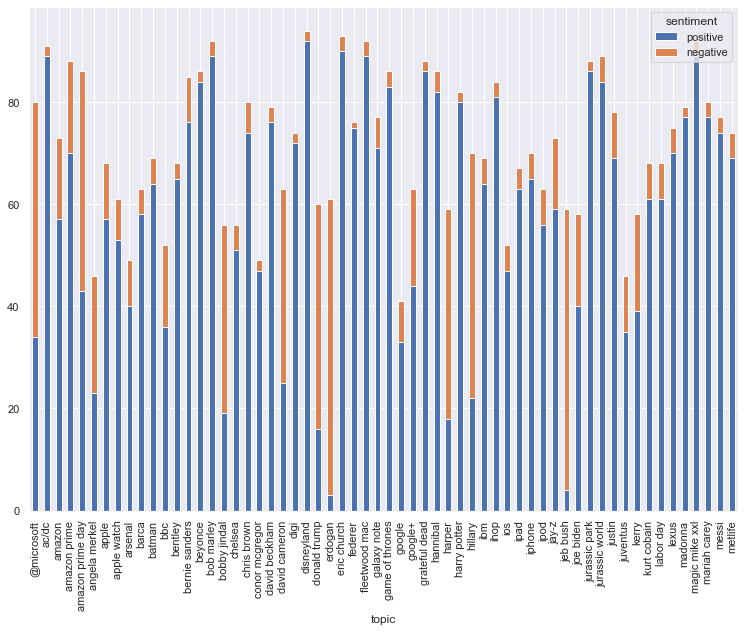

In [13]:
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot

human_sentiment = list(set(tweets['sentiment'].tolist()))
df_sentiment = tweets.groupby(['topic', 'sentiment'])['topic'].count().unstack('sentiment')
topic_mixture = df_sentiment[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [14]:
# What does the human anotated set of topics look like
human_topics = list(set(tweets['topic'].tolist()))
print(human_topics)

['game of thrones', 'google', 'ac/dc', 'magic mike xxl', 'beyonce', 'apple watch', 'google+', 'jurassic park', 'justin', 'disneyland', 'bobby jindal', 'bob marley', 'hillary', 'chelsea', 'iphone', 'ipad', 'batman', 'bbc', 'kurt cobain', 'jurassic world', 'david beckham', 'donald trump', 'apple', 'juventus', 'lexus', 'kerry', 'chris brown', 'harry potter', 'mariah carey', 'angela merkel', 'jay-z', 'bernie sanders', 'amazon prime day', 'bentley', 'jeb bush', 'digi', 'grateful dead', 'ipod', 'ios', 'amazon prime', 'eric church', 'galaxy note', 'david cameron', 'metlife', 'labor day', 'hannibal', 'madonna', 'messi', 'ihop', 'conor mcgregor', 'ibm', 'fleetwood mac', 'barca', 'amazon', 'harper', 'arsenal', 'erdogan', 'federer', '@microsoft', 'joe biden']


In [15]:
# Prepare the corpus for analysis and checking first 10 entries

corpus = []

for i in range(len(tweets['Tweet'])):
    tweet = tweets['Tweet'][i]
    
    # For topic modeling we will remove the url's for consdieration as terms in our topics
    #tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', "", tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Uncomment the following to remove hashtags and mentions
    #tweet = re.sub(r'#\w+ ?', '', tweet)
    #tweet = re.sub(r'@\w+ ?', '', tweet)
    
    # OR, uncomment the following to remove the character tags for mentions and hashtags
    #tweet = tweet.replace("@", "").replace("#", "")
    
    tweet = tweet.replace("&amp;", " ").replace("&gt;", "").replace("&lt;", "")
    tweet = tweet.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").replace(",", "")
    tweet = tweet.replace("/", " ").replace("=", "").replace('\"', "").replace('*', '').replace(';', "")
    tweet = tweet.replace(':', '').replace('"', '')
    tweet = re.sub(r'\$[0-9]+', '', tweet)
    tweet = re.sub(r'[0-9]+GB', '', tweet)
    tweet = re.sub(r'[0-9]+', '', tweet)
    tweet = re.sub(r'--+', ' ', tweet)
    
    corpus.append(tweet)

# Dump out the first 10 tweets to see what the parsing has done
corpus[0:10]

["dear @Microsoft the newOoffice for Mac is great and all but no Lync update C'mon",
 "@Microsoft how about you make a system that doesn't eat my friggin discs This is the nd time this has happened and I am so sick of it",
 "I may be ignorant on this issue but should we celebrate @Microsoft's parental leave changes Doesn't the gender divide suggest  ",
 'Thanks to @microsoft I just may be switching over to @apple',
 'Microsoft I may not prefer your gaming branch of business But you do make a damn fine operating system #Windows @Microsoft',
 '@MikeWolf @Microsoft I will be downgrading and let #Windows be out for almost the st yr b trying it again #Windowsfail',
 '@Microsoft nd computer with same error #Windowsfail Guess we will shelve this until SP ',
 'Just ordered my st ever tablet @Microsoft Surface Pro  i   SSD Hopefully it works out for dev to replace my laptop ',
 'After attempting a reinstall it still bricks says Windows cannot finish installing or somesuch @Microsoft may have co

In [16]:
# If our temp folder is not present, create it. 

TEMP_FOLDER = temp_file_path
if os.path.exists(TEMP_FOLDER) == False:
    os.mkdir(TEMP_FOLDER)

#### gensim LDA does not use the words directly when determining topics but instead uses ids as representations for the words. The mapping between ids and words is stored in a python dictionary. 

In [17]:
# Now that we have done some prep of the corpus we can perform some additonal word level processing to remove 
# extraneous tokens and common stopwords that do not contribute our discovery of topics in the corpus.

# Define our stoplist for removing common words and tokenizing
list1 = ['RT','rt', '&amp;', 'im', 'b4', 'yr', 'nd', 'rd', 'oh', "can't", "he's", "i'll",
         "i'm", 'ta', "'s", "c'mon", 'th', 'st', "that's", "they're", "i've", 'am', 'pm']
stoplist = stopwords.words('english') + list(string.punctuation) + list1
#print(stoplist)

# Remove tokens in the text that match our stoplist tokens and lower case all tokens
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

# Create and save the dictionary, in case we want to reload it into another notebook
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'semval.dict'))  # store the dictionary, for future reference

In [19]:
# What is the averge length of the documents in the corpus?
text_length = []
for t in texts:
    text_length.append(len(t))
    
tweets['doc_length'] = pd.Series(text_length)

avg_doc_length = tweets['doc_length'].mean() 
median_doc_length = tweets['doc_length'].median()
min_doc_length = tweets['doc_length'].min()
max_doc_length = tweets['doc_length'].max()

print("Average tweet length: {}".format(avg_doc_length))
print("Median tweet length: {}".format(median_doc_length))
print("Minimum tweet length: {}".format(min_doc_length))
print("Maximum tweet length: {}".format(max_doc_length))


Average tweet length: 11.128800185657925
Median tweet length: 11.0
Minimum tweet length: 2
Maximum tweet length: 573


In [20]:
# Found some anomalies in the input training data set that resulted in very long tweets.
# Code below is a chedk that I corrected all the anomalies

tweets_filtered = tweets[tweets['doc_length'] > 40]
tweets_filtered.head()

outliers = tweets_filtered['Tweet'].tolist()
print(outliers)

["@106andpark: Did you enjoy last night's Life Of Chris Brown? Next Tuesday we explore the career of @TreySongz! #BETTreySongz\n641665418046783488\tchris brown\tpositive\tWel looks like I'm going to the after party tomorrow with fetty wap Chris brown tyga etc thanks to my cuz\n641669138679758848\tchris brown\tpositive\tSo when is game &amp; Chris Brown homie Gonna fight ???  Is it on pay per view or Friday night hood fights ??\n620092023375159296\tconor mcgregor\tpositive\tConor McGregor backed up the talk and won interim gold with 2nd Round TKO. http://t.co/XAadtJ8IUV http://t.co/wP5juh3vQB\n620092635756298240\tconor mcgregor\tpositive\tConor McGregor vs Frankie Edgar may be even better than tonight's fight\n620092929957212160\tconor mcgregor\tnegative\tnever in my life will I root for Conor McGregor. one day ... (and that day may never come) .. someone will demolish him. #oneDay #UFC189\n620093063621275648\tconor mcgregor\tpositive\tWOW. Conor McGregor with a 2nd round stoppage just 

In [21]:
# Dump out the dictionay to examine list of resulting tokens
print(dictionary.token2id)

{'@microsoft': 0, 'dear': 1, 'great': 2, 'lync': 3, 'mac': 4, 'newooffice': 5, 'update': 6, 'discs': 7, "doesn't": 8, 'eat': 9, 'friggin': 10, 'happened': 11, 'make': 12, 'sick': 13, 'system': 14, 'time': 15, "@microsoft's": 16, 'celebrate': 17, 'changes': 18, 'divide': 19, 'gender': 20, 'ignorant': 21, 'issue': 22, 'leave': 23, 'may': 24, 'parental': 25, 'suggest': 26, '@apple': 27, 'switching': 28, 'thanks': 29, '#windows': 30, 'branch': 31, 'business': 32, 'damn': 33, 'fine': 34, 'gaming': 35, 'microsoft': 36, 'operating': 37, 'prefer': 38, '#windowsfail': 39, '@mikewolf': 40, 'almost': 41, 'b': 42, 'downgrading': 43, 'let': 44, 'trying': 45, 'computer': 46, 'error': 47, 'guess': 48, 'shelve': 49, 'sp': 50, 'dev': 51, 'ever': 52, 'hopefully': 53, 'laptop': 54, 'ordered': 55, 'pro': 56, 'replace': 57, 'ssd': 58, 'surface': 59, 'tablet': 60, 'works': 61, 'attempting': 62, 'bricks': 63, 'cannot': 64, 'cost': 65, 'finish': 66, 'installing': 67, 'reinstall': 68, 'says': 69, 'somesuch': 7

#### gensim LDA stores all the text for processing into a corpus object. All text is filtered through the previously constructed dictionary

In [22]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'semval.mm'), corpus)  # store to disk, for later use

In [23]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]      # step 2 -- use the model to transform vectors

##### Reference for lda parameters: https://radimrehurek.com/gensim/models/ldamodel.html

In [24]:
# Use the number of human annotated topics by commenting out the second total_topics assignment 
total_topics = len(human_topics)
total_topics = 20

# Experiment with the alpha assingment to investigate alpha parameter settings on topic assignments
lda_alpha = 'auto' #learns asymmetic prior from the corpus
lda_alpha = 'symmetric'
#lda_alpha = 'asymmetric'  # sets alpha = 1 / number_of_topics
#lda_alpha = np.full((total_topics), (0.05 * avg_doc_length) / total_topics)  # from NIH paper

In [25]:
#
lda = models.LdaModel(corpus, id2word = dictionary, num_topics = total_topics, iterations = 1000, alpha=lda_alpha)
corpus_lda = lda[corpus] # Use the bow corpus

In [26]:
#Show first n=80 important words in the topics:
lda.show_topics(total_topics, 10)

[(0,
  '0.040*"tomorrow" + 0.020*"ipad" + 0.017*"gonna" + 0.015*"day" + 0.014*"players" + 0.012*"make" + 0.011*"top" + 0.011*"ok" + 0.011*"today" + 0.011*"see"'),
 (1,
  '0.018*"till" + 0.015*"yep" + 0.013*"like" + 0.012*"history" + 0.012*"talking" + 0.012*"hour" + 0.011*"voice" + 0.011*"least" + 0.011*"concerts" + 0.010*"mom"'),
 (2,
  '0.173*"messi" + 0.018*"tomorrow" + 0.016*"ladies" + 0.014*"game" + 0.014*"may" + 0.010*"time" + 0.009*"like" + 0.009*"ever" + 0.008*"don\'t" + 0.008*"tuesday"'),
 (3,
  '0.030*"player" + 0.029*"best" + 0.017*"world" + 0.014*"chesney" + 0.014*"kenny" + 0.014*"james" + 0.012*"jay-z" + 0.012*"may" + 0.012*"someone" + 0.011*"miss"'),
 (4,
  '0.022*"la" + 0.022*"liga" + 0.019*"top" + 0.011*"sevilla" + 0.010*"haven\'t" + 0.010*"rest" + 0.010*"green" + 0.009*"thurs" + 0.009*"hey" + 0.009*"instagram"'),
 (5,
  '0.021*"grateful" + 0.019*"comes" + 0.018*"time" + 0.017*"christmas" + 0.017*"dead" + 0.015*"tomorrow" + 0.012*"may" + 0.012*"sat" + 0.012*"see" + 0.011

In [27]:
# Load the topic - term data into an python dictionary
data_lda = {i: OrderedDict(lda.show_topic(i,20)) for i in range(total_topics)}
data_lda

{0: OrderedDict([('tomorrow', 0.040361136),
              ('ipad', 0.02029471),
              ('gonna', 0.016896835),
              ('day', 0.0146845365),
              ('players', 0.01409494),
              ('make', 0.011803158),
              ('top', 0.011419334),
              ('ok', 0.011283068),
              ('today', 0.0111692855),
              ('see', 0.011115532),
              ('end', 0.010911658),
              ('pack', 0.010600355),
              ('happiest', 0.0102072805),
              ('world', 0.009181302),
              ('watch', 0.0072074314),
              ('weekend', 0.006994657),
              ('number', 0.00691319),
              ('excited', 0.0069026942),
              ('coming', 0.0068356805),
              ('may', 0.00682934)]),
 1: OrderedDict([('till', 0.018002547),
              ('yep', 0.014895291),
              ('like', 0.012914288),
              ('history', 0.012293343),
              ('talking', 0.0116624525),
              ('hour', 0.01164924),
     

In [28]:
# Use the ordered dictionary to load the data into a dataframe
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(20, 254)


In [29]:
# A dataframe view of some of terms across topics

df_lda.head(20)

,tomorrow,ipad,gonna,day,players,make,top,ok,today,see,...,feeling,jason,sing,mac,fleetwood,playing,neymar,friends,never,music
0,0.040361,0.020295,0.016897,0.014685,0.014095,0.011803,0.011419,0.011283,0.011169,0.011116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.008457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007840,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.017656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.007365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018512,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.015034,0.000000,0.006536,0.009589,0.000000,0.000000,0.000000,0.000000,0.000000,0.011694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.026275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014787,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.011015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.007348,0.000000,0.000000,0.021009,0.000000,0.000000,0.000000,0.000000,0.000000,0.013630,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='tsne')
#panel

#### We have some idea of the topic distribution from the preceding cell but no real idea how lda matched the human annotated topics. 

In [31]:
parsed_tweets = tweets.filter(['msgid', 'topic', 'sentiment'], axis =1)
se = pd.Series(texts)
parsed_tweets['Tweet'] = se

In [32]:
parsed_tweets.to_csv(os.path.join(data_file_path, "parsed_tweets.csv"), sep="\t")
parsed_tweets.head(10)

,msgid,topic,sentiment,Tweet
0,628949369883000832,@microsoft,negative,"[dear, @microsoft, newooffice, mac, great, lyn..."
1,628976607420645377,@microsoft,negative,"[@microsoft, make, system, doesn't, eat, frigg..."
2,629023169169518592,@microsoft,negative,"[may, ignorant, issue, celebrate, @microsoft's..."
3,629179223232479232,@microsoft,negative,"[thanks, @microsoft, may, switching, @apple]"
4,629226490152914944,@microsoft,positive,"[microsoft, may, prefer, gaming, branch, busin..."
5,629345637155360768,@microsoft,negative,"[@mikewolf, @microsoft, downgrading, let, #win..."
6,629394528336637953,@microsoft,negative,"[@microsoft, computer, error, #windowsfail, gu..."
7,629650766580609026,@microsoft,positive,"[ordered, ever, tablet, @microsoft, surface, p..."
8,629797991826722816,@microsoft,negative,"[attempting, reinstall, still, bricks, says, w..."
9,630159517058142208,@microsoft,positive,"[sunday, morning, quiet, day, time, welcome, #..."


In [33]:
# A check of the data types included in parsed_tweets

#parsed_tweets.dtypes

In [34]:
# Run the original documents back thru the model to infer the distribution of topics 
# according to the lda model

topics = []
probs = []
max_to_show = 20

for k, i in enumerate(range(len(parsed_tweets['Tweet']))):
    bow = dictionary.doc2bow(parsed_tweets['Tweet'][i])
    doc_topics = lda.get_document_topics(bow, minimum_probability = 0.01)
    topics_sorted = sorted(doc_topics, key = lambda x: x[1], reverse = True)
    topics.append(topics_sorted[0][0])
    probs.append("{}".format(topics_sorted[0][1]))
    
    # Dump out the topic and probability assignments for the first 20 documents
    if k < max_to_show:
        print("Document {}: {}".format(k, topics_sorted))

parsed_tweets['LDAtopic'] = pd.Series(topics)
parsed_tweets['LDAprob'] = pd.Series(probs)

Document 0: [(2, 0.8808478)]
Document 1: [(17, 0.8059553), (11, 0.11207826)]
Document 2: [(9, 0.7245839), (19, 0.14551592), (3, 0.06430024)]
Document 3: [(4, 0.84153426)]
Document 4: [(0, 0.9320041)]
Document 5: [(13, 0.90471965)]
Document 6: [(4, 0.8810547)]
Document 7: [(12, 0.6663045), (0, 0.18875548), (2, 0.07933348)]
Document 8: [(12, 0.715139), (16, 0.14614344), (19, 0.07780047)]
Document 9: [(0, 0.9049761)]
Document 10: [(18, 0.7871484), (10, 0.076320395), (6, 0.071062624)]
Document 11: [(3, 0.9365511)]
Document 12: [(16, 0.89413303)]
Document 13: [(15, 0.9044172)]
Document 14: [(10, 0.9267152)]
Document 15: [(4, 0.92065364)]
Document 16: [(16, 0.77155626), (13, 0.16404825)]
Document 17: [(7, 0.75243473), (16, 0.10988512), (5, 0.08449321)]
Document 18: [(1, 0.64355385), (18, 0.27443546)]
Document 19: [(4, 0.86066717), (15, 0.07002854)]


In [35]:
# Resort the dataframe according to the human annotated topic and lda topic
parsed_tweets.sort_values(['topic', 'LDAtopic'], ascending=[True, True], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,LDAtopic,LDAprob
4,629226490152914944,@microsoft,positive,"[microsoft, may, prefer, gaming, branch, busin...",0,0.9320040941238403
9,630159517058142208,@microsoft,positive,"[sunday, morning, quiet, day, time, welcome, #...",0,0.9049761295318604
21,632805868334153728,@microsoft,negative,"[@microsoft, normal, takes, hours, check, emai...",0,0.8491114377975464
29,633757225945665537,@microsoft,positive,"[traveled, redmond, today, visiting, @microsof...",0,0.8475595712661743
32,634098901025484800,@microsoft,negative,"[call, john, @microsoft, hello, i'd, like, loo...",0,0.537765622138977
40,634728738941456384,@microsoft,positive,"[register, nacr, skype, business, event, @micr...",0,0.9266854524612427
42,634921865916452864,@microsoft,negative,"[told, time, case, number, escalated, level, i...",0,0.9207401275634766
61,639102028296376320,@microsoft,negative,"[diff, @microsoft, bitlocker, point, platforms...",0,0.9134360551834106
18,631843393971204097,@microsoft,positive,"[@taehongmin, iot, workshop, @microsoft, frida...",1,0.6435538530349731
38,634657299680858113,@microsoft,negative,"[@microsoft, limited, time, eternally, lasting...",1,0.9207015633583069


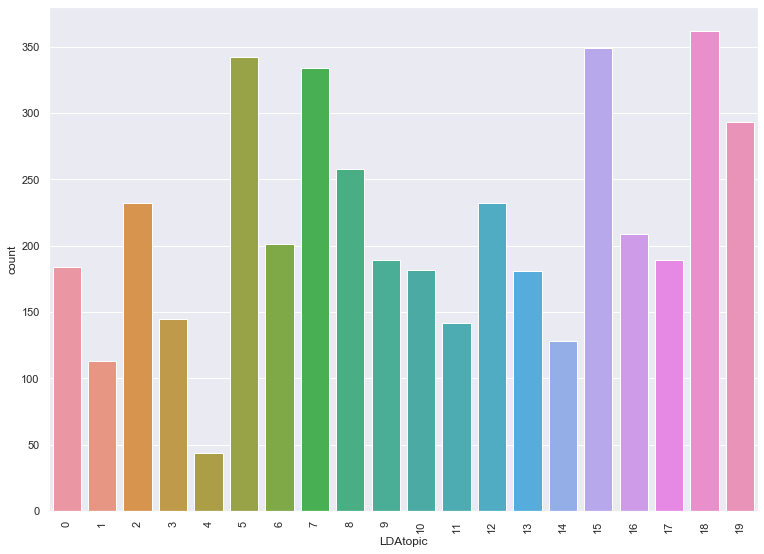

In [36]:
# Take a look at the distributions of human annotated topics in the data via a barplot

sns.set(rc={'figure.figsize':(12.7,9.27)})
by_topic = sns.countplot(x='LDAtopic', data=parsed_tweets)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [37]:
# Resort the dataframe according to the the lda assigned topic and the human annotated topic

parsed_tweets.sort_values(['LDAtopic', 'topic'], ascending=[True, True], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,LDAtopic,LDAprob
4,629226490152914944,@microsoft,positive,"[microsoft, may, prefer, gaming, branch, busin...",0,0.9320040941238403
9,630159517058142208,@microsoft,positive,"[sunday, morning, quiet, day, time, welcome, #...",0,0.9049761295318604
21,632805868334153728,@microsoft,negative,"[@microsoft, normal, takes, hours, check, emai...",0,0.8491114377975464
29,633757225945665537,@microsoft,positive,"[traveled, redmond, today, visiting, @microsof...",0,0.8475595712661743
32,634098901025484800,@microsoft,negative,"[call, john, @microsoft, hello, i'd, like, loo...",0,0.537765622138977
40,634728738941456384,@microsoft,positive,"[register, nacr, skype, business, event, @micr...",0,0.9266854524612427
42,634921865916452864,@microsoft,negative,"[told, time, case, number, escalated, level, i...",0,0.9207401275634766
61,639102028296376320,@microsoft,negative,"[diff, @microsoft, bitlocker, point, platforms...",0,0.9134360551834106
175,641242217881948160,amazon,positive,"[watch, amazon, may, nnouncing, tablet, holida...",0,0.68917316198349
178,641256781428183042,amazon,positive,"[october, amazon, us, uk, thanks, heads, @that...",0,0.6315231323242188


In [38]:
# Resort the dataframe according to the the lda assigned topic and the assocoiated probability
parsed_tweets.sort_values(['LDAtopic', 'LDAprob'], ascending=[True, False], inplace=True)
parsed_tweets.head(20)

,msgid,topic,sentiment,Tweet,LDAtopic,LDAprob
1806,635467067358056452,erdogan,negative,"[@rconflictnews, possibly, right, erdogan, low...",0,0.9404674172401428
1941,635547743872774144,federer,positive,"[great, day, world, sport, usain, got, gold, f...",0,0.9365125298500061
1708,640427226391953408,donald trump,positive,"[@realdonaldtrump, @foxnews, @karlrove, silent...",0,0.9320370554924011
4,629226490152914944,@microsoft,positive,"[microsoft, may, prefer, gaming, branch, busin...",0,0.9320040941238403
520,641659630595244032,apple,positive,"[#appleevent, new, watch, faces, rd-party, com...",0,0.9319970607757568
1077,630886601762082817,bob marley,positive,"[sun, shining, writing, deck, seems, like, bob...",0,0.9268136024475098
501,641647415997526016,apple,positive,"[hours, go, apple, event, here's, word, street...",0,0.9268131852149963
1147,640198736665276416,bob marley,positive,"[tomorrow, night, jamrock, hull, @tofts_lane_h...",0,0.9267526865005493
40,634728738941456384,@microsoft,positive,"[register, nacr, skype, business, event, @micr...",0,0.9266854524612427
1068,630298927154266112,bob marley,positive,"[sun, shining, weather, sweet, makes, wanna, m...",0,0.9207442402839661


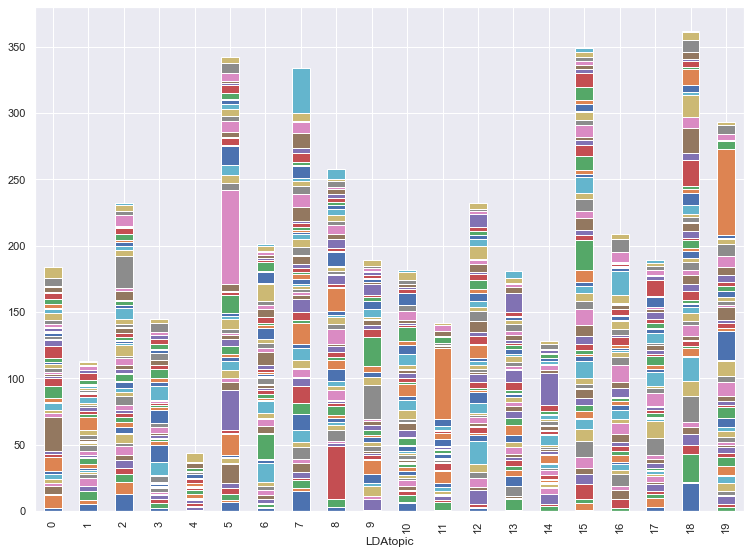

In [39]:
# What do the topic distrubtions look like relative to the original human annotated/tagged topics

df2 = parsed_tweets.groupby(['LDAtopic', 'topic'])['LDAtopic'].count().unstack('topic')
topic_mixture = df2[human_topics].plot(kind='bar', stacked=True, legend = False)


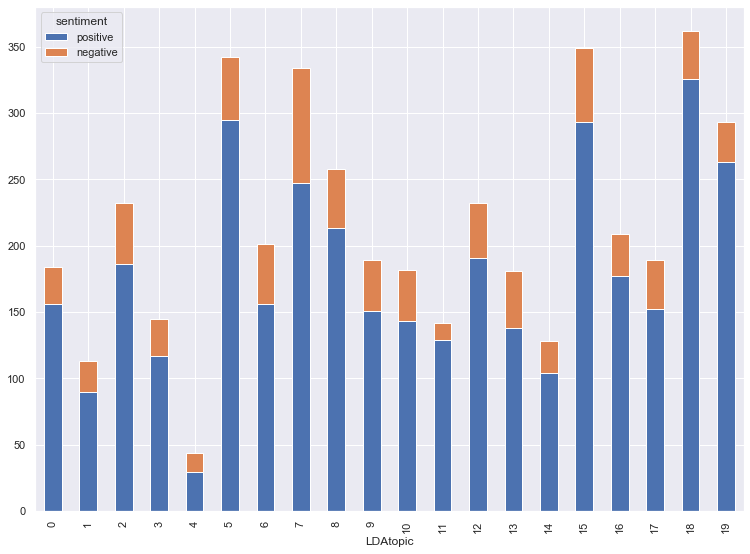

In [40]:
# What do the topic distrubtions look like relative to the original human annotated/tagged sentiment

human_sentiment = list(set(parsed_tweets['sentiment'].tolist()))
df2 = parsed_tweets.groupby(['LDAtopic', 'sentiment'])['LDAtopic'].count().unstack('sentiment')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [41]:
# A major question in using LDA for topic modeling is what is is the proper set of
# hyperparmeters to generate the optimal set of topics for the coprus of documents
# under examination. Gensim includes methods for computing the Perplexity and Topic 
# Coherence of a corpus. One appraoch to is to sample an LDA model for a range of 
# for perplexity and topic coherence and select the appropriate number of topics
# from a point of minimum perplexity and maximium topic coherence.

corpus = [dictionary.doc2bow(text) for text in texts]
perplexity_lda = []
coherence_lda = []
topic_count_lda = []

for num_topics in range(15, 70, 5):
    
    print("Computing the lda model using {} topics".format(num_topics))
    
    topic_lda = models.LdaModel(corpus,
                                id2word = dictionary,
                                num_topics = total_topics,
                                iterations = 1000,
                                alpha = lda_alpha)
    corpus_lda = topic_lda[corpus] # Use the bow corpus
    
    topic_count_lda.append(num_topics)
    
    perplexity_lda.append(topic_lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    cm = CoherenceModel(model=topic_lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda.append(cm.get_coherence())
    

#cm = CoherenceModel(model=lda, corpus=corpus, dictionay=dictionary, coherence='c_v')
#coherence_lda = cm.get_coherence()
#print('\nCoherence Score (c_v): ', coherence_lda)

Computing the lda model using 15 topics
Computing the lda model using 20 topics
Computing the lda model using 25 topics
Computing the lda model using 30 topics
Computing the lda model using 35 topics
Computing the lda model using 40 topics
Computing the lda model using 45 topics
Computing the lda model using 50 topics
Computing the lda model using 55 topics
Computing the lda model using 60 topics
Computing the lda model using 65 topics


In [42]:
# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'perplexity': perplexity_lda,
                           'coherence': coherence_lda},
                         index = topic_count_lda)

topics_lda.head(10)

,perplexity,coherence
15,-12.150302,-11.734652
20,-12.168307,-11.692268
25,-12.144721,-11.104993
30,-12.169769,-11.467020
35,-12.161116,-11.508583
40,-12.172365,-11.079189
45,-12.174678,-11.250210
50,-12.162849,-12.021696
55,-12.169153,-11.496069
60,-12.151367,-11.957332


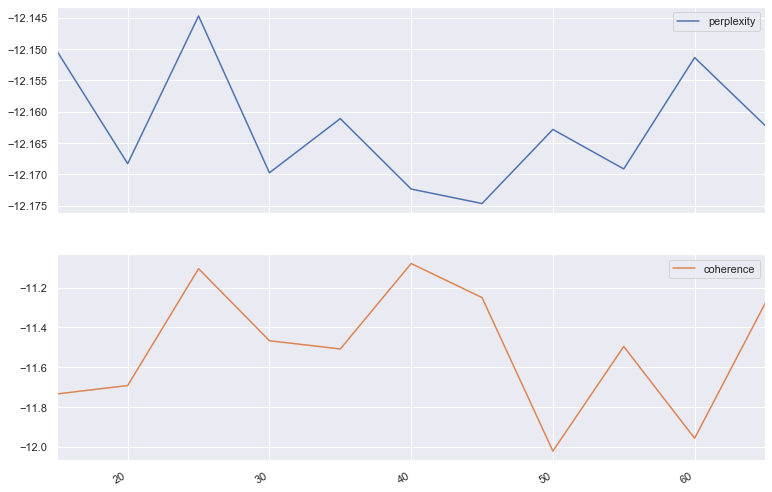

In [43]:
lines = topics_lda.plot.line(subplots = True)

##### Gensim also includes Hierarchical Dirichlet process (HDP). HDP is a powerful mixed-membership model for 
the unsupervised analysis of grouped data. Unlike its finite counterpart, latent Dirichlet allocation, 
the HDP topic model infers the number of topics from the data. Here we have used Online HDP, 
which provides the speed of online variational Bayes with the modeling flexibility of the HDP.

See https://radimrehurek.com/gensim/models/hdpmodel.html

In [44]:
# Create a HDP model - default for hdp is 150
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [45]:
hdptopics = hdpmodel.show_topics(num_topics = 20, formatted=True)
hdptopics

[(0,
  "0.006*conor + 0.006*mcgregor + 0.003*positive + 0.002*may + 0.001*tomorrow + 0.001*night + 0.001*#playthegame + 0.001*round + 0.001*next + 0.001*church + 0.001*like + 0.001*saturday + 0.001*hearts + 0.001*sunday + 0.001*#ufc + 0.001*harper's + 0.001*won + 0.001*see + 0.001*last + 0.001*birthday"),
 (1,
  "0.002*may + 0.002*see + 0.001*tomorrow + 0.001*prime + 0.001*don't + 0.001*amazon + 0.001*note + 0.001*day + 0.001*get + 0.001*galaxy + 0.001*take + 0.001*bard + 0.001*go + 0.001*jarring + 0.001*political + 0.001*tickets + 0.001*ios + 0.001*@jmilam + 0.001*watch + 0.001*metal"),
 (2,
  "0.001*may + 0.001*back + 0.001*tomorrow + 0.001*prime + 0.001*potter + 0.001*painful + 0.001*got + 0.001*refusing + 0.001*saturday + 0.001*messi + 0.001*prolly + 0.001*'injury' + 0.001*squeezed + 0.001*wednesday + 0.001*intentional + 0.001*elevate + 0.001*concern + 0.001*broken + 0.001*kasich + 0.001*harry"),
 (3,
  "0.001*may + 0.001*tomorrow + 0.001*press + 0.001*planner + 0.001*woohoo + 0.00

In [46]:
hdp_topics = hdpmodel.get_topics()
hdp_topics.shape

(150, 11237)

In [47]:
hdpmodel.hdp_to_lda()

(array([0.00926106, 0.01202745, 0.00962393, 0.01103577, 0.01128535,
        0.00821965, 0.00882386, 0.011051  , 0.00572689, 0.00730263,
        0.00914942, 0.00846386, 0.00795499, 0.00710312, 0.0091378 ,
        0.00804986, 0.00890213, 0.00822488, 0.0073105 , 0.00843655,
        0.00897135, 0.00740468, 0.00534189, 0.00900792, 0.01065158,
        0.00780541, 0.00769142, 0.0081109 , 0.00821175, 0.00703168,
        0.00819573, 0.00607206, 0.00734138, 0.00734672, 0.0080135 ,
        0.00744591, 0.00697297, 0.00851957, 0.00752061, 0.009015  ,
        0.00728569, 0.008706  , 0.00595948, 0.00767841, 0.0080019 ,
        0.00716227, 0.00752254, 0.00926993, 0.00580051, 0.00828489,
        0.00730131, 0.00695227, 0.00535466, 0.00783176, 0.00612325,
        0.00760245, 0.00586935, 0.00782457, 0.00614785, 0.00649574,
        0.0067017 , 0.0064757 , 0.0073196 , 0.00685628, 0.00561556,
        0.00623044, 0.00671941, 0.00567829, 0.00727206, 0.00709611,
        0.00704997, 0.00732592, 0.00548368, 0.00